In [145]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, precision_recall_curve, f1_score, auc 
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression, chi2
import datetime
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score, accuracy_score,log_loss

In [146]:
df = pd.read_csv('df.csv')

/Users/kasey.larsen/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [90]:
# Correct dtpes
df['pageviews'] = df['pageviews'].astype(int)
df['newVisits'] = df['newVisits'].astype(int)
df['bounces'] = df['bounces'].astype(int)
df['hits_y'] = df['hits_y'].astype(int)
df['sessionQualityDim'] = df['sessionQualityDim'].astype(int)
df['timeOnSite'] = df['timeOnSite'].astype(int)
df['transactions'] = df['transactions'].astype(int)
df['totalTransactionRevenue'] = df['totalTransactionRevenue'].astype(int)
df['fullVisitorId'] = df['fullVisitorId'].astype(str)
df['visitId'] = df['visitId'].astype(str)

In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82707 entries, 0 to 82706
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   fullVisitorId            82707 non-null  object 
 1   channelGrouping          82707 non-null  object 
 2   visitId                  82707 non-null  object 
 3   visitNumber              82707 non-null  int64  
 4   visitStartTime           82707 non-null  float64
 5   browser                  82707 non-null  object 
 6   operatingSystem          82707 non-null  object 
 7   isMobile                 82707 non-null  int64  
 8   deviceCategory           82707 non-null  object 
 9   subContinent             82707 non-null  object 
 10  hits_y                   82707 non-null  int64  
 11  pageviews                82707 non-null  int64  
 12  bounces                  82707 non-null  int64  
 13  newVisits                82707 non-null  int64  
 14  sessionQualityDim     

### Creating Dummy Regressors

In [92]:
#Get dummies for catergorical data
df = pd.get_dummies(df, columns=['channelGrouping'], prefix=['channel'])
df = pd.get_dummies(df, columns=['browser'], prefix=['browser'])
df = pd.get_dummies(df, columns=['operatingSystem'], prefix=['operatingSystem'])
df = pd.get_dummies(df, columns=['deviceCategory'], prefix=['deviceCategory'])
df = pd.get_dummies(df, columns=['subContinent'], prefix=['subContinent'])
df = pd.get_dummies(df, columns=['source'], prefix=['source'])

### Spliting data to Train/Test

In [95]:
## SHOULD I ADD X = np.log(X) HERE?
X = df.drop(columns='totalTransactionRevenue', axis = 1)
y = df.totalTransactionRevenue

In [96]:
#Get train/test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=47)

In [97]:
#checking shape
X_train.shape, X_test.shape

((57894, 77), (24813, 77))

In [98]:
#checking shape
y_train.shape, y_test.shape

((57894,), (24813,))

In [99]:
#Save the 'fullVisitorId', 'visitId' columns from the train/test data into names_train and names_test
#Then drop those columns from `X_train` and `X_test`
id_list = ['fullVisitorId']
id_train = X_train[id_list]
id_test = X_test[id_list]
X_train = X_train.drop(columns=id_list)
X_test = X_test.drop(columns=id_list)

((57894, 75), (24813, 75))

### Dummy Regressor

In [102]:
#Calculate the mean of `y_train`
train_mean = y_train.mean()
train_mean

1919598.7494386293

In [103]:
#Fit the dummy regressor on the training data
dumb_reg = DummyRegressor(strategy='mean')
dumb_reg.fit(X_train, y_train)
dumb_reg.constant_

array([[1919598.74943863]])

### R-Squared

In [104]:
y_train_pred_ = train_mean * np.ones(len(y_train))
y_train_pred_[:5]

array([1919598.74943863, 1919598.74943863, 1919598.74943863,
       1919598.74943863, 1919598.74943863])

In [105]:
y_train_pred = dumb_reg.predict(X_train)
y_test_pred = train_mean * np.ones(len(y_test))

In [106]:
r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)

(0.0, -0.00014508860797213252)

### Mean Absolute Error

In [107]:
mean_absolute_error(y_train, y_train_pred), mean_absolute_error(y_test, y_test_pred)

(3796424.80418047, 3441745.9292575517)

### Mean Squared Error

In [108]:
np.sqrt(mean_squared_error(y_train, y_train_pred)), np.sqrt(mean_squared_error(y_test, y_test_pred))

(126973925.10459916, 29029381.47879413)

### Scaling Data

In [109]:
#Call the StandardScaler`s fit method
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Feature Selection

#### Feature importance based on mean decrease in impurity

In [110]:
feature_names = [f'feature {i}' for i in range(X_train.shape[1])]
forest = RandomForestClassifier(random_state=0)
forest.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [111]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

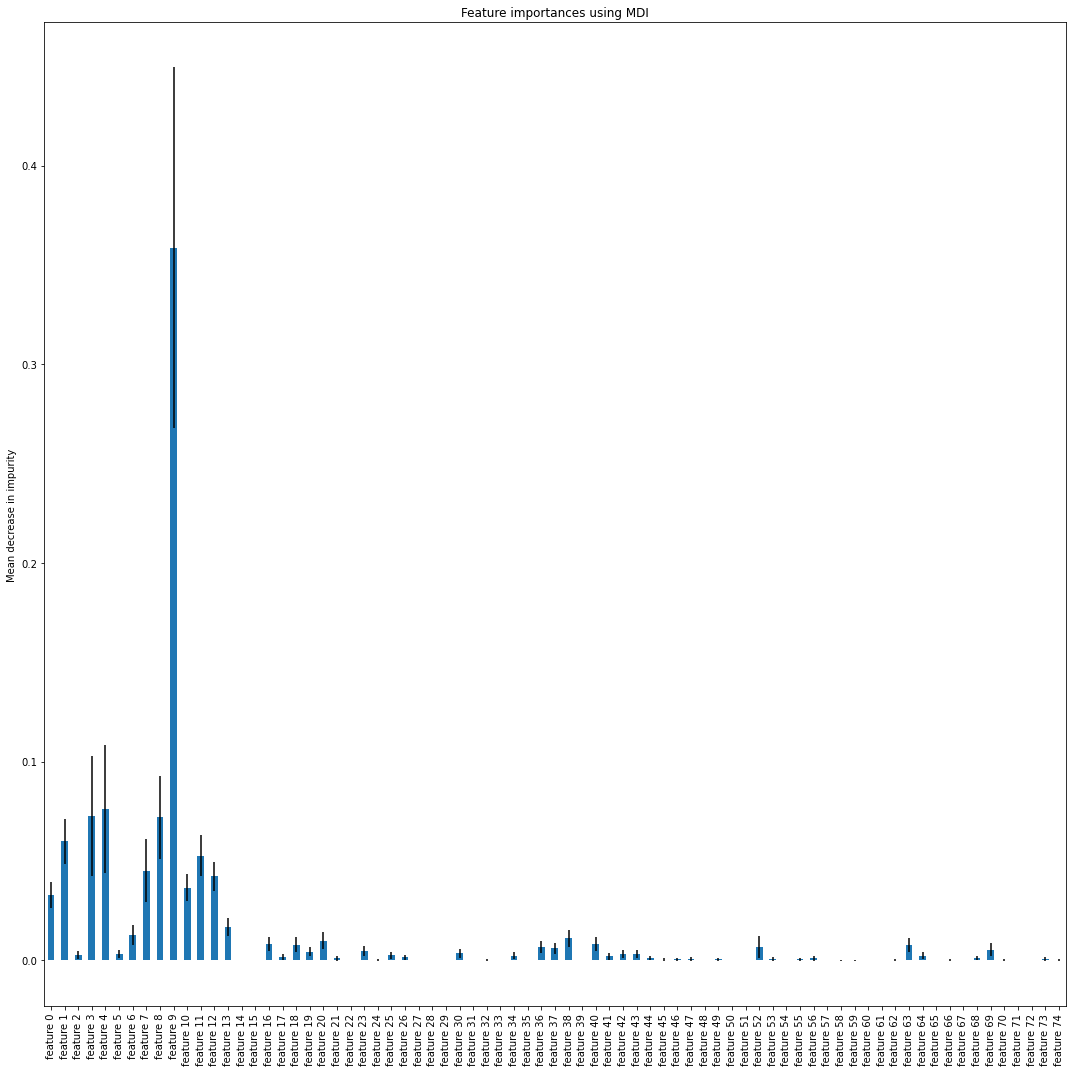

In [112]:
## DOES FEATURE SELECTION WORK WELL WITH THE DUMMIES?
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots(figsize=(15,15))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [113]:
pd.set_option('display.max_rows', 80)

In [149]:
forest_importances.sort_values(ascending=False).head(15)

feature 9     0.000109
feature 0     0.000032
feature 40    0.000024
feature 38    0.000020
feature 12    0.000012
feature 1     0.000008
feature 10    0.000004
feature 49    0.000000
feature 54    0.000000
feature 53    0.000000
feature 52    0.000000
feature 51    0.000000
feature 50    0.000000
feature 47    0.000000
feature 48    0.000000
dtype: float64

#### Feature importance based on feature permutation

In [116]:
from sklearn.inspection import permutation_importance


result = permutation_importance(forest, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
forest_importances = pd.Series(result.importances_mean, index=feature_names)

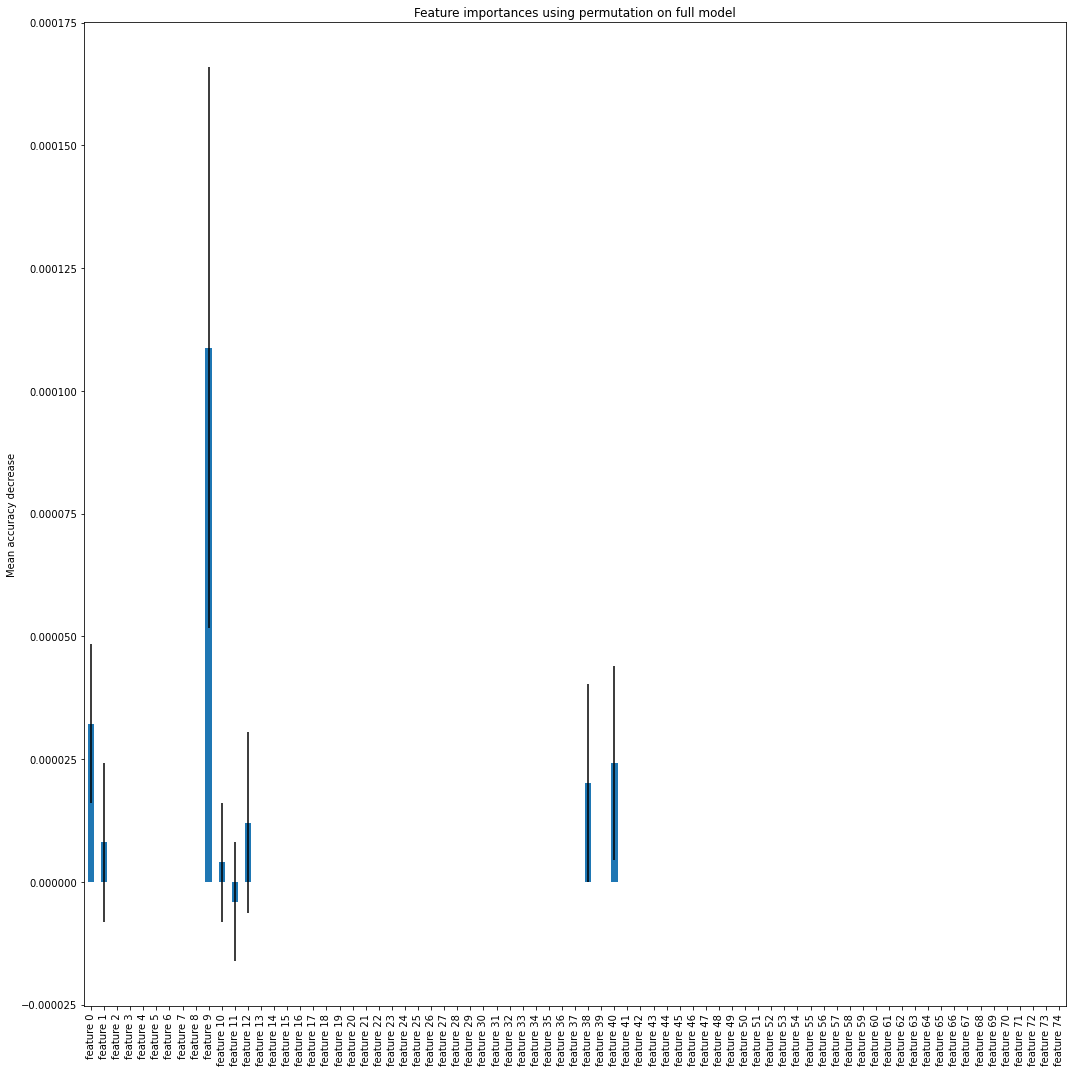

In [117]:
fig, ax = plt.subplots(figsize=(15,15))
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [118]:
forest_importances.sort_values(ascending=False).head(10)

feature 9     0.000109
feature 0     0.000032
feature 40    0.000024
feature 38    0.000020
feature 12    0.000012
feature 1     0.000008
feature 10    0.000004
feature 49    0.000000
feature 54    0.000000
feature 53    0.000000
dtype: float64

### Hyperparameter search using GridSearchCV

In [119]:
pipe = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler(),
    SelectKBest(f_regression),
    LinearRegression()
)

In [120]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(score_func=<function f_regression at 0x7fe730836d30>)),
                ('linearregression', LinearRegression())])

In [121]:
y_train_pred = pipe.predict(X_train)
y_test_pred = pipe.predict(X_test)

In [122]:
r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)

(0.36216362816800907, -3.451261364538942)

In [123]:
mean_absolute_error(y_train, y_train_pred), mean_absolute_error(y_test, y_test_pred)

(29796485.828165486, 29815715.842430938)

### Cross Validation

In [124]:
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'simpleimputer', 'standardscaler', 'selectkbest', 'linearregression', 'simpleimputer__add_indicator', 'simpleimputer__copy', 'simpleimputer__fill_value', 'simpleimputer__missing_values', 'simpleimputer__strategy', 'simpleimputer__verbose', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'selectkbest__k', 'selectkbest__score_func', 'linearregression__copy_X', 'linearregression__fit_intercept', 'linearregression__n_jobs', 'linearregression__normalize', 'linearregression__positive'])

In [125]:
k = [k+1 for k in range(len(X_train.columns))]
grid_params = {'selectkbest__k': k}

In [126]:
lr_grid_cv = GridSearchCV(pipe, param_grid=grid_params, cv=5, n_jobs=-1)

In [127]:
lr_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(strategy='median')),
                                       ('standardscaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x7fe730836d30>)),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1,
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                            12, 13, 14, 15, 16, 17, 18, 19, 20,
                                            21, 22, 23, 24, 25, 26, 27, 28, 29,
                                            30, ...]})

In [128]:
score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]
lr_grid_cv.best_params_

{'selectkbest__k': 1}

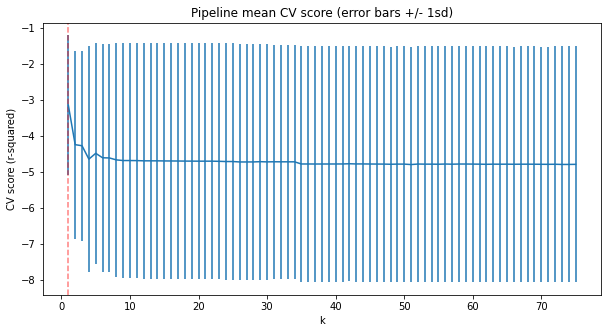

In [129]:
best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

In [130]:
selected = lr_grid_cv.best_estimator_.named_steps.selectkbest.get_support()

In [131]:
pd.options.display.max_rows = 4000

In [132]:
coefs = lr_grid_cv.best_estimator_.named_steps.linearregression.coef_
features = X_train.columns[selected]
pd.Series(coefs, index=features).sort_values(ascending=False)

pageviews    5.676820e+07
dtype: float64

### Random Forest

In [133]:
RF_pipe = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler(),
    RandomForestRegressor(random_state=47)
)

In [134]:
rf_default_cv_results = cross_validate(RF_pipe, X_train, y_train, cv=5)

In [135]:
rf_cv_scores = rf_default_cv_results['test_score']
rf_cv_scores

array([-0.41295815, -0.13746116,  0.07352926, -0.01051229, -0.13885493])

In [136]:
np.mean(rf_cv_scores), np.std(rf_cv_scores)

(-0.12525145585531194, 0.1647957074019922)

### Random Forest Hyperparameter search using GridSearchCV

In [137]:
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
grid_params = {
        'randomforestregressor__n_estimators': n_est,
        'standardscaler': [StandardScaler(), None],
        'simpleimputer__strategy': ['mean', 'median']
}
grid_params

{'randomforestregressor__n_estimators': [10,
  12,
  16,
  20,
  26,
  33,
  42,
  54,
  69,
  88,
  112,
  143,
  183,
  233,
  297,
  379,
  483,
  615,
  784,
  1000],
 'standardscaler': [StandardScaler(), None],
 'simpleimputer__strategy': ['mean', 'median']}

In [138]:
rf_grid_cv = GridSearchCV(RF_pipe, param_grid=grid_params, cv=5, n_jobs=-1)

In [139]:
rf_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(strategy='median')),
                                       ('standardscaler', StandardScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=47))]),
             n_jobs=-1,
             param_grid={'randomforestregressor__n_estimators': [10, 12, 16, 20,
                                                                 26, 33, 42, 54,
                                                                 69, 88, 112,
                                                                 143, 183, 233,
                                                                 297, 379, 483,
                                                                 615, 784,
                                                                 1000],
                         'simpleimputer__strategy': [

In [140]:
rf_grid_cv.best_params_

{'randomforestregressor__n_estimators': 1000,
 'simpleimputer__strategy': 'mean',
 'standardscaler': None}

In [141]:
rf_best_cv_results = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, cv=5)
rf_best_scores = rf_best_cv_results['test_score']
rf_best_scores

array([-0.40281575,  0.03385434,  0.07598411,  0.01193771, -0.09215504])

In [142]:
np.mean(rf_best_scores), np.std(rf_best_scores)

(-0.07463892418771205, 0.17318224026047627)

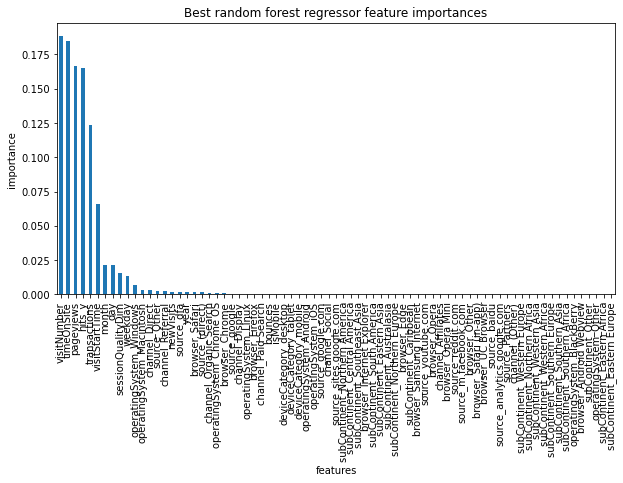

In [143]:
plt.subplots(figsize=(10, 5))
imps = rf_grid_cv.best_estimator_.named_steps.randomforestregressor.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest regressor feature importances');

In [144]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=10, random_state = 1,n_jobs=-1)
model_res = clf.fit(X_train_scaled, y_train)
y_pred = model_res.predict(X_test_scaled)
y_pred_prob = model_res.predict_proba(X_test_scaled)
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

Random Forest: Accuracy=0.988
Random Forest: f1-score=0.984
